# Emotion Extraction and Classification from Twitter Text
Emotion is one of the basic instincts of a human being. Emotion detection plays a vital role in the field of textual analysis. At present, people’s expressions and emotional states have turned into the leading topic for research works. Emotion Detection and Recognition from texts are recent fields of research that are closely related to Emotion Analysis. Emotion Analysis aims at detecting and recognizing feelings through the expressions from sentences, such as *anger*, *surprise*, *joy*, *fear*, *sadness*, *love* etc.

**Course No:** CSE4238

**Course Name:** Soft Computing Lab

**Course Teachers**


*   Nibir Chandra Mandol
*   Sanzana Karim Lora



**Team Members**

*   160204107 - Nowshin Rumali
*   170104116 - Rejone-E-Rasul Hridoy
*   170104118 - Mehedi Hasan Sami
*   170104136 - Sabiha Nasrin Jyoti






In [ ]:
import random
import time
import pandas as pd
import numpy as np
import re
import torch
import string

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

from tensorflow. keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from torch.optim.optimizer import Optimizer

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore")

root_path = "/content/drive/MyDrive/CSE/4.2/CSE4238 - Soft Computing Lab/Project - Emotion Detection from Twitter Text/"

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Parameters

In [ ]:
embed_size = 300 # how big is each word vector
max_features = 100000 # how many unique words to use (i.e num rows in embedding vector)
maxlen = 70 # max number of words in a question to use

# 1. Dataset

In [ ]:
data = pd.read_csv(root_path+"Dataset/text_emotions.csv")
data.head()

,content,sentiment
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


## 1.1 Finding the Length

In [ ]:
data['length'] = data['content'].apply(lambda x: len(str(x).split()))
data

,content,sentiment,length
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,21
2,im grabbing a minute to post i feel greedy wrong,anger,10
3,i am ever feeling nostalgic about the fireplac...,love,18
4,i am feeling grouchy,anger,4
...,...,...,...
19995,im having ssa examination tomorrow in the morn...,sadness,34
19996,i constantly worry about their fight against n...,joy,29
19997,i feel its important to share this info for th...,joy,15
19998,i truly feel that if you are passionate enough...,joy,19


## 1.2 Text Preprocessing

In [ ]:
emojis = pd.read_csv(root_path+'emojis.txt',sep=',',header=None)
emojis_dict = {i:j for i,j in zip(emojis[0],emojis[1])}
pattern = '|'.join(sorted(re.escape(k) for k in emojis_dict))

def replace_emojis(text):
    text = re.sub(pattern,lambda m: emojis_dict.get(m.group(0)), text, flags=re.IGNORECASE)
    return text

def remove_punct(text):
    text = replace_emojis(text)
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

def clean_text(x):
    pattern = r'[^a-zA-z0-9\s]'
    text = re.sub(pattern, '', x)
    return x

contraction_dict = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am","im":"i am", "I've": "I have", "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have", "you're": "you are", "you've": "you have"}
def _get_contractions(contraction_dict):
    contraction_re = re.compile('(%s)' % '|'.join(contraction_dict.keys()))
    return contraction_dict, contraction_re
contractions, contractions_re = _get_contractions(contraction_dict)

def replace_contractions(text):
    def replace(match):
        return contractions[match.group(0)]
    return contractions_re.sub(replace, text)
# Usage
replace_contractions("i didn't feel humiliated")

def text_preprocessing(text):
    text = replace_contractions(text)
    text = remove_punct(text)
    text = clean_text(text)
    text = text.lower()
    return text


In [ ]:
data["content"] = data["content"].apply(lambda x: text_preprocessing(x))
data

,content,sentiment,length
0,i didnt feel humiliated,sadness,4
1,i can go from feeling so hopeless to so damned...,sadness,21
2,i am grabbing a minute to post i feel greedy w...,anger,10
3,i am ever feeling nostalgic about the fireplac...,love,18
4,i am feeling grouchy,anger,4
...,...,...,...
19995,i am having ssa examination tomorrow in the mo...,sadness,34
19996,i constantly worry about their fight against n...,joy,29
19997,i feel its i amportant to share this info for ...,joy,15
19998,i truly feel that if you are passionate enough...,joy,19


In [ ]:
data['sentiment'].unique()

array(['sadness', 'anger', 'love', 'surprise', 'fear', 'joy'],
      dtype=object)

## 1.3 Train Test Split
  Train Size = 80%

  Test Size = 20%

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data['content'], data['sentiment'],
                                                    stratify=data['sentiment'], 
                                                    test_size=0.2)

In [ ]:
print("Train shape : ",X_train.shape)
print("Test shape : ",X_test.shape)

Train shape :  (16000,)
Test shape :  (4000,)


## 1.4 Padding Dataset
  Maximum Length = 70

In [ ]:
## Tokenize the sentences
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(X_train))
train_X = tokenizer.texts_to_sequences(X_train)
test_X = tokenizer.texts_to_sequences(X_test)

## Pad the sentences
train_X = pad_sequences(train_X, maxlen=maxlen, truncating='post', padding='post')
test_X = pad_sequences(test_X, maxlen=maxlen, truncating='post', padding='post')

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
train_y = le.fit_transform(y_train.values)
test_y = le.transform(y_test.values)
le.classes_

array(['anger', 'fear', 'joy', 'love', 'sadness', 'surprise'],
      dtype=object)

# 2. Word Emebedding (Glove.6B.300d)

## 2.1 Load Embeddings


In [ ]:
def load_glove(word_index):
    EMBEDDING_FILE = root_path+'Word Embedding (glove 6B)/glove.6B.300d.txt'
    def get_coefs(word,*arr): return word, np.asarray(arr, dtype='float32')[:300]
    embeddings_index = dict(get_coefs(*o.split(" ")) for o in open(EMBEDDING_FILE))
    
    all_embs = np.stack(embeddings_index.values())
    emb_mean,emb_std = -0.005838499,0.48782197
    embed_size = all_embs.shape[1]

    nb_words = min(max_features, len(word_index)+1)
    embedding_matrix = np.random.normal(emb_mean, emb_std, (nb_words, embed_size))
    for word, i in word_index.items():
        if i >= max_features: continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None: 
            embedding_matrix[i] = embedding_vector
        else:
            embedding_vector = embeddings_index.get(word.capitalize())
            if embedding_vector is not None: 
                embedding_matrix[i] = embedding_vector
    return embedding_matrix
embedding_matrix = load_glove(tokenizer.word_index)
print('Shape of word embedding:',np.shape(embedding_matrix))

Shape of word embedding: (15176, 300)


# 3. Convolutional Neural Network (CNN)

In [ ]:
class CNN(nn.Module):
    
    def __init__(self,num_filters,filter_sizes,n_classes):
        super(CNN, self).__init__()

        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.convs1 = nn.ModuleList([nn.Conv2d(1, num_filters, (K, embed_size)) for K in filter_sizes])
        self.dropout = nn.Dropout(0.1)
        self.fc1 = nn.Linear(len(filter_sizes)*num_filters, n_classes)

    def forward(self, x):
        x = self.embedding(x) 
        x = x.unsqueeze(1)  
        x = [F.relu(conv(x)).squeeze(3) for conv in self.convs1] 
        x = [F.max_pool1d(i, i.size(2)).squeeze(2) for i in x]  
        x = torch.cat(x, 1)
        x = self.dropout(x)  
        logit = self.fc1(x)
        return logit

## 3.1 Setting Hyperparameters

In [ ]:
n_epochs = 30
filter_sizes = [2,3,5]
num_filters = 32
n_classes = len(le.classes_)
batch_size = 512

## 3.2 Model Evaluation

In [ ]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_cnn = CNN(num_filters,filter_sizes,n_classes).to(device)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_cnn.parameters()), lr=0.001)

# Load train and test in CUDA or CPU Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

cnn_train_loss = []
cnn_valid_loss = []
cnn_train_acc_list, cnn_test_acc_list, cnn_prec_list, cnn_recall_list, cnn_f1_list = [],[],[],[],[]

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model_cnn.train()
    avg_loss = 0.  
    train_preds = np.zeros((len(x_train),len(le.classes_)))
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model_cnn(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).detach().cpu().numpy()
        avg_loss += loss.item() / len(train_loader)

    
    y_pred_train = train_preds.argmax(axis=1)
    train_accuracy = round(accuracy_score(y_pred_train,train_y)*100,3)
    
    # Set model to validation configuration -Doesn't get trained here
    model_cnn.eval()      
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model_cnn(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Determining Accuracy, Precision, Recall, F1 Score
    y_pred = val_preds.argmax(axis=1)
    test_accuracy = round(accuracy_score(y_pred,test_y)*100,3)
    test_precision = round(precision_score(y_pred,test_y, average='weighted')*100,3)
    test_recall = round(np.mean(recall_score(y_pred, test_y, average='weighted'))*100,3)
    test_f1_score = round(f1_score(y_pred, test_y, average='weighted')*100,3)
  

    # storing accuracy,precision,recall,f1 score data into list
    cnn_train_loss.append(avg_loss)
    cnn_valid_loss.append(avg_val_loss)
    cnn_train_acc_list.append(train_accuracy)
    cnn_test_acc_list.append(test_accuracy)
    cnn_prec_list.append(test_precision)
    cnn_recall_list.append(test_recall)
    cnn_f1_list.append(test_f1_score)
    elapsed_time = time.time() - start_time
    print('Epoch {}/{}  Train loss={:.3f}   Test loss={:.3f}   Train Accuracy={:.3f}   Test Accuracy={:.3f}   Precision={:.3f}   Recall={:.3f}   F1 Score={:.3f}   time={:.2f} s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, train_accuracy, test_accuracy, test_precision, test_recall, test_f1_score, elapsed_time))

Epoch 1/30  Train loss=1.506   Test loss=1.311   Train Accuracy=42.312   Test Accuracy=53.225   Precision=84.878   Recall=53.225   F1 Score=65.235   time=1.23 s
Epoch 2/30  Train loss=1.117   Test loss=0.901   Train Accuracy=60.362   Test Accuracy=69.325   Precision=82.144   Recall=69.325   F1 Score=73.246   time=0.87 s
Epoch 3/30  Train loss=0.773   Test loss=0.635   Train Accuracy=73.731   Test Accuracy=78.225   Precision=81.585   Recall=78.225   F1 Score=79.054   time=0.87 s
Epoch 4/30  Train loss=0.567   Test loss=0.493   Train Accuracy=81.181   Test Accuracy=82.750   Precision=83.859   Recall=82.750   F1 Score=83.000   time=0.87 s
Epoch 5/30  Train loss=0.449   Test loss=0.418   Train Accuracy=85.125   Test Accuracy=84.850   Precision=85.500   Recall=84.850   F1 Score=84.950   time=0.87 s
Epoch 6/30  Train loss=0.375   Test loss=0.367   Train Accuracy=87.425   Test Accuracy=86.850   Precision=87.158   Recall=86.850   F1 Score=86.897   time=0.86 s
Epoch 7/30  Train loss=0.324   Tes

## 3.3 Save a Model

In [ ]:
save_model = False
if save_model is True:
    torch.save(model_cnn,root_path+'Model Checkpoints/cnn_model_300d_epoch30.pkl')

## 3.4 Load a Mdoel

In [ ]:
load_model = False
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Model Checkpoints/cnn_model_300d_epoch30.pkl'))

## 3.5 Model Visualization

### 3.5.1 Model Performance of CNN

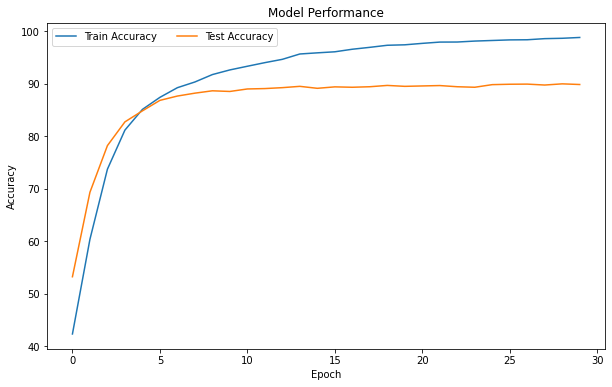

In [ ]:
plt.plot(cnn_train_acc_list, linestyle='-', label='Train Accuracy')
plt.plot(cnn_test_acc_list, linestyle='-', label='Test Accuracy')

plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='bottom right',ncol=2)
# plt.ylim(5.55,11.55)
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig(root_path+'Figures/final_cnn_model_performance_300d_epoch30.jpg')
plt.show()

### 3.5.2 Loss Curve of CNN

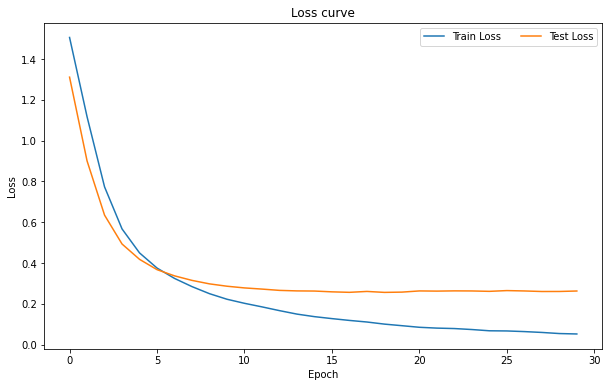

In [ ]:
plt.plot(cnn_train_loss, linestyle='-', label='Train Loss')
plt.plot(cnn_valid_loss, linestyle='-', label='Test Loss')

plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='bottom right',ncol=2)
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig(root_path+'Figures/final_cnn_loss_curve_300d_epoch30.jpg')
plt.show()

### 3.5.3 Confusion Matrix

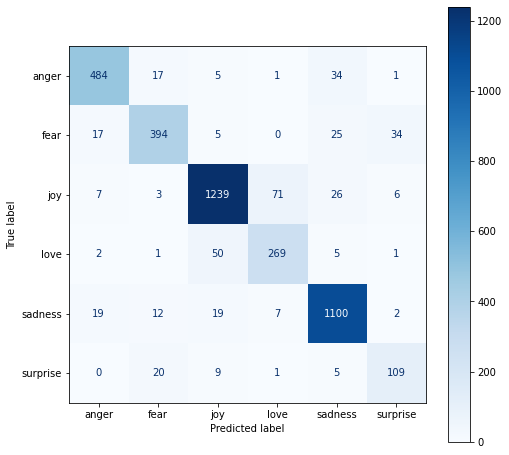

In [ ]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]

cnn_cm = confusion_matrix(y_true, y_pred, labels=le.classes_)
cm_display = ConfusionMatrixDisplay(cnn_cm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(8,8)) # adjust the size
cm_display.plot(ax=ax,cmap='Blues',values_format='')

# 4. Bidirectional Long Short Term Memory (Bi-LSTM)

## 4.1 Setting Hyperparameters

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self,n_classes):
        super(BiLSTM, self).__init__()
        n_classes = len(le.classes_)
        self.hidden_size = 64
        self.embedding = nn.Embedding(max_features, embed_size)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False
        self.lstm = nn.LSTM(embed_size, self.hidden_size,num_layers=1, bidirectional=True, batch_first=True)
        self.linear = nn.Linear(self.hidden_size*4 , 32)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)
        self.out = nn.Linear(32, n_classes)
        

    def forward(self, x):
        h_embedding = self.embedding(x)
        h_lstm, _ = self.lstm(h_embedding)
        avg_pool = torch.mean(h_lstm, 1)
        max_pool, _ = torch.max(h_lstm, 1)
        conc = torch.cat(( avg_pool, max_pool), 1)
        conc = self.relu(self.linear(conc))
        conc = self.dropout(conc)
        out = self.out(conc)
        return out

## 4.2 Model Evaluation

In [ ]:
model = BiLSTM(n_classes).to(device)
loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001)

# Load train and test in CUDA or CPU Memory
x_train = torch.tensor(train_X, dtype=torch.long).to(device)
y_train = torch.tensor(train_y, dtype=torch.long).to(device)
x_cv = torch.tensor(test_X, dtype=torch.long).to(device)
y_cv = torch.tensor(test_y, dtype=torch.long).to(device)

# Create Torch datasets
train = torch.utils.data.TensorDataset(x_train, y_train)
valid = torch.utils.data.TensorDataset(x_cv, y_cv)

# Create Data Loaders
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid, batch_size=batch_size, shuffle=False)

train_loss = []
valid_loss = []
train_acc_list, test_acc_list, prec_list, recall_list, f1_list = [],[],[],[],[]

for epoch in range(n_epochs):
    start_time = time.time()
    # Set model to train configuration
    model.train()
    avg_loss = 0.  
    train_preds = np.zeros((len(x_train),len(le.classes_)))
    for i, (x_batch, y_batch) in enumerate(train_loader):
        # Predict/Forward Pass
        y_pred = model(x_batch)

        # Compute loss
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).detach().cpu().numpy()
        avg_loss += loss.item() / len(train_loader)

    
    y_pred_train = train_preds.argmax(axis=1)
    train_accuracy = round(accuracy_score(y_pred_train,train_y)*100,3)
    
    # Set model to validation configuration -Doesn't get trained here
    model.eval()        
    avg_val_loss = 0.
    val_preds = np.zeros((len(x_cv),len(le.classes_)))
    
    for i, (x_batch, y_batch) in enumerate(valid_loader):
        y_pred = model(x_batch).detach()
        avg_val_loss += loss_fn(y_pred, y_batch).item() / len(valid_loader)
        # keep/store predictions
        val_preds[i * batch_size:(i+1) * batch_size] =F.softmax(y_pred).cpu().numpy()
    
    # Check Accuracy
    y_pred = val_preds.argmax(axis=1)
    test_accuracy = round(accuracy_score(y_pred,test_y)*100,3)
    test_precision = round(precision_score(y_pred,test_y, average='weighted')*100,3)
    test_recall = round(np.mean(recall_score(y_pred, test_y, average='weighted'))*100,3)
    test_f1_score = round(f1_score(y_pred, test_y, average='weighted')*100,3)
  

    # storing accuracy,precision,recall,f1 score data into list
    train_loss.append(avg_loss)
    valid_loss.append(avg_val_loss)
    train_acc_list.append(train_accuracy)
    test_acc_list.append(test_accuracy)
    prec_list.append(test_precision)
    recall_list.append(test_recall)
    f1_list.append(test_f1_score)
    elapsed_time = time.time() - start_time 
    print('Epoch {}/{}  Train loss={:.3f}   Test loss={:.3f}   Train Accuracy={:.3f}   Test Accuracy={:.3f}   Precision={:.3f}   Recall={:.3f}   F1 Score={:.3f}   time={:.2f} s'.format(
                epoch + 1, n_epochs, avg_loss, avg_val_loss, train_accuracy, test_accuracy, test_precision, test_recall, test_f1_score, elapsed_time))

Epoch 1/30  Train loss=1.614   Test loss=1.558   Train Accuracy=31.825   Test Accuracy=35.525   Precision=95.347   Recall=35.525   F1 Score=50.183   time=1.62 s
Epoch 2/30  Train loss=1.504   Test loss=1.358   Train Accuracy=43.706   Test Accuracy=52.825   Precision=83.725   Recall=52.825   F1 Score=64.594   time=1.61 s
Epoch 3/30  Train loss=1.251   Test loss=1.124   Train Accuracy=54.069   Test Accuracy=56.500   Precision=89.887   Recall=56.500   F1 Score=68.694   time=1.46 s
Epoch 4/30  Train loss=1.065   Test loss=0.956   Train Accuracy=57.556   Test Accuracy=59.300   Precision=91.069   Recall=59.300   F1 Score=70.826   time=1.47 s
Epoch 5/30  Train loss=0.867   Test loss=0.710   Train Accuracy=66.594   Test Accuracy=74.875   Precision=84.580   Recall=74.875   F1 Score=78.437   time=1.46 s
Epoch 6/30  Train loss=0.637   Test loss=0.516   Train Accuracy=77.812   Test Accuracy=83.200   Precision=86.978   Recall=83.200   F1 Score=84.893   time=1.47 s
Epoch 7/30  Train loss=0.488   Tes

## 4.3 Save a Model

In [ ]:
save_model = False
if save_model is True:
    torch.save(model,root_path+'Model Checkpoints/final_bilstm_model_300d_layer1_epoch30.pkl')

## 4.4 Load the Model

In [ ]:
load_model = False
if load_model is True:
    model.load_state_dict(torch.load(root_path + 'Model Checkpoints/bilstm_model_300d_layer1_epoch30.pkl'))

## 4.5 Model Visualization

### 4.5.1 Model Performance of Bi-LSTM

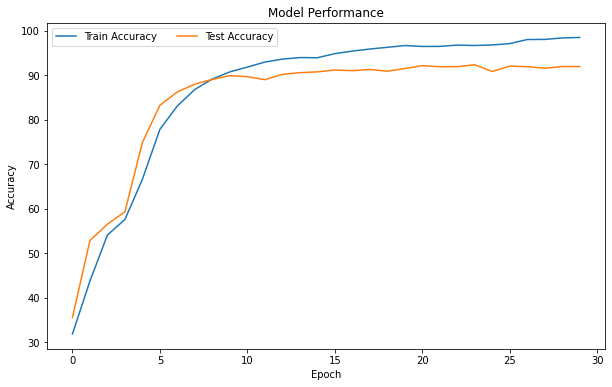

In [ ]:
plt.plot(train_acc_list, linestyle='-', label='Train Accuracy')
plt.plot(test_acc_list, linestyle='-', label='Test Accuracy')

plt.title('Model Performance')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='bottom right',ncol=2)
# plt.ylim(5.55,11.55)
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig(root_path+'Figures/final_BiLSTM_model_performance_300d_layer1_epoch30.jpg')
plt.show()

### 4.5.2 Loss Curve of Bi-LSTM

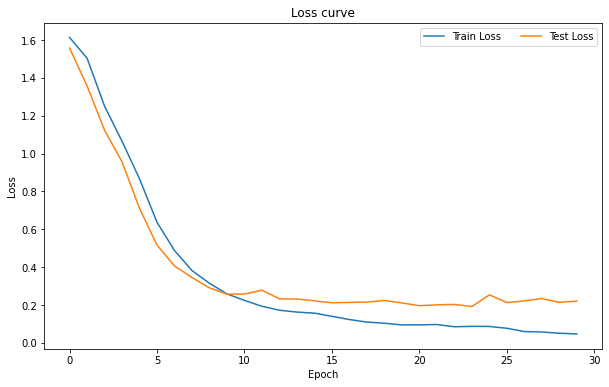

In [ ]:
plt.plot(train_loss, linestyle='-', label='Train Loss')
plt.plot(valid_loss, linestyle='-', label='Test Loss')

plt.title('Loss curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='bottom right',ncol=2)
plt.rcParams["figure.figsize"] = (10,6)
plt.savefig(root_path+'Figures/final_BiLSTM_loss_curve_300d_layer1_epoch30.jpg')
plt.show()

### 4.5.3 Confusion Matrix of Bi-LSTM

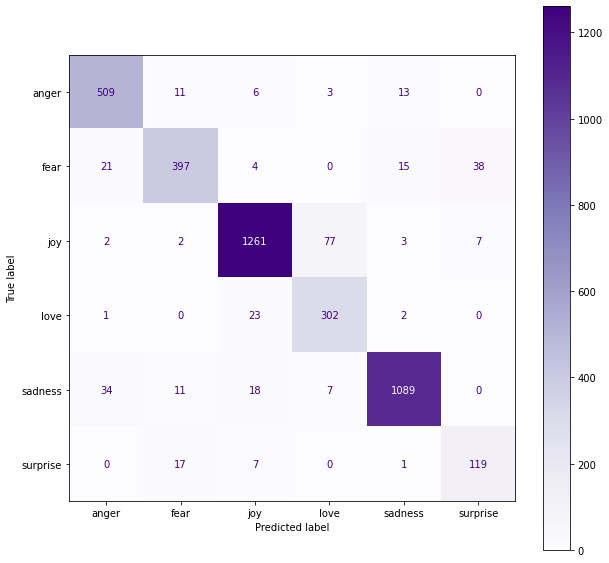

In [ ]:
y_true = [le.classes_[x] for x in test_y]
y_pred = [le.classes_[x] for x in val_preds.argmax(axis=1)]

cm_bilstm = confusion_matrix(y_true, y_pred, labels=le.classes_)
cm_display = ConfusionMatrixDisplay(cm_bilstm, display_labels=le.classes_)
fig, ax = plt.subplots(figsize=(10,10)) # adjust the size
cm_display.plot(ax=ax,cmap='Purples',values_format='')
plt.savefig(root_path+'Figures/final_BiLSTM_confusion_matrix_300d_layer1_epoch30.jpg')

# 5. Model Summary

## 5.1 Comparison

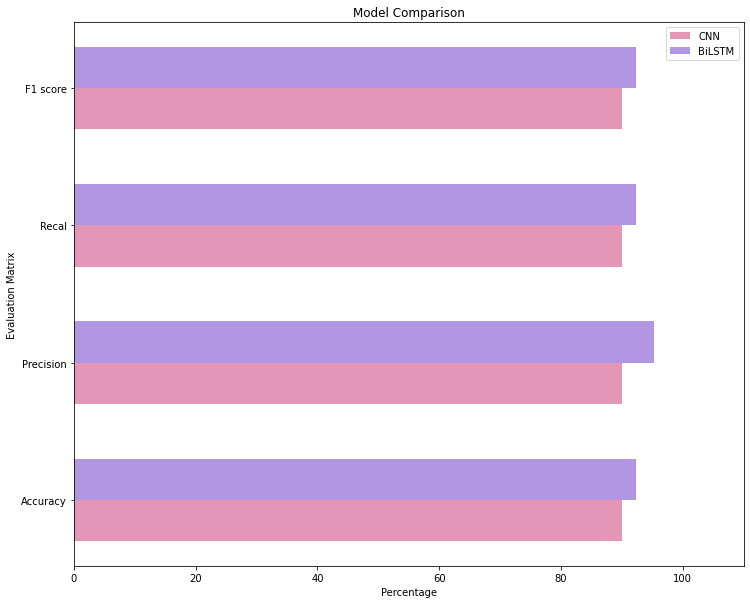

In [ ]:
fig = plt.figure(figsize = (12, 10))
w =0.3
x_axis = ["Accuracy","Precision","Recal","F1 score"]
cnn = []
cnn.append(max(cnn_test_acc_list))
cnn.append(max(cnn_prec_list))
cnn.append(max(cnn_recall_list))
cnn.append(max(cnn_f1_list))
bilstm = []
bilstm.append(max(test_acc_list))
bilstm.append(max(prec_list))
bilstm.append(max(recall_list))
bilstm.append(max(f1_list))

bar1 = np.arange(len(x_axis))
bar2 = [i+w for i in bar1]

plt.barh(bar1,cnn,w,label='CNN',color='#E396B6')
plt.barh(bar2,bilstm,w,label='BiLSTM',color='#B096E3')

plt.xlabel("Percentage")
plt.ylabel("Evaluation Matrix")
plt.title("Model Comparison")
plt.yticks((bar2+bar1)/2,x_axis)
plt.xlim(0,110)
plt.savefig(root_path+'Figures/final_all_model_performance_epoch30.jpg')
plt.legend()
plt.show()

In [ ]:
def get_prec_recall_per_emotion(cm):
    per_emotion_precision = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[j][i]
            count_per_emotion += cm[j][i]
        per_emotion_precision.append(round((accurate/count_per_emotion)*100,3))
        
    per_emotion_recall = []
    for i in range(len(cm)):
        count_per_emotion,accurate = 0,0
        for j in range(len(cm)):
            if i == j:
                accurate = cm[i][j]
            count_per_emotion += cm[i][j]
        per_emotion_recall.append(round((accurate/count_per_emotion)*100,3))
        
    return per_emotion_precision, per_emotion_recall

## 5.2 Model Precision of all emotions

In [ ]:
bilstm_per_prec,bilstm_per_recall = get_prec_recall_per_emotion(cm_bilstm)
cnn_per_prec,cnn_per_recall = get_prec_recall_per_emotion(cnn_cm)
per_precision_list = pd.DataFrame({'CNN': cnn_per_prec,
                              'Bi-LSTM' : bilstm_per_prec}, 
                                index=le.classes_)
per_precision_list

,CNN,Bi-LSTM
anger,91.493,89.771
fear,88.143,90.639
joy,93.369,95.603
love,77.077,77.635
sadness,92.050,96.972
surprise,71.242,72.561


## 5.3 Model Recall of all emotions

In [ ]:
per_recall_list = pd.DataFrame({'CNN': cnn_per_recall,
                        'Bi-LSTM' : bilstm_per_recall}, 
                                index=le.classes_)
per_recall_list

,CNN,Bi-LSTM
anger,89.299,93.911
fear,82.947,83.579
joy,91.642,93.269
love,82.012,92.073
sadness,94.909,93.960
surprise,75.694,82.639


# 6. Prediction

In [ ]:
def predict_single(x):    
    x = text_preprocessing(x)
    # tokenize
    x = tokenizer.texts_to_sequences([x])
    # pad
    x = pad_sequences(x, maxlen=maxlen)
    # create dataset
    x = torch.tensor(x, dtype=torch.long).to(device)

    pred_cnn = model_cnn(x).detach()
    pred_cnn = F.softmax(pred_cnn).cpu().numpy()
    pred_cnn = pred_cnn.argmax(axis=1)
    pred_cnn = le.classes_[pred_cnn]

    pred_bilstm = model(x).detach()
    pred_bilstm = F.softmax(pred_bilstm).cpu().numpy()
    pred_bilstm = pred_bilstm.argmax(axis=1)
    pred_bilstm = le.classes_[pred_bilstm]
    return pred_cnn[0],pred_bilstm[0]

In [ ]:
input_string = input('Input Text: ')
cnn_pred, bilstm_pred = predict_single(input_string)
print('Emotion using CNN:',cnn_pred)
print('Emotion using BiLSTM:',bilstm_pred)

Input Text: i feel like a miserable piece of garbage
Emotion using CNN: sadness
Emotion using BiLSTM: sadness
